In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../adiabatic-tides")
sys.path.append("..")

import adiabatic_tides as at
import cusp_encounters.milkyway
import cusp_encounters.encounters_math as em
import scipy.constants as const

%load_ext autoreload
cachedir = "../caches"

G = 43.0071057317063e-10 # Mpc (km/s)^2 / Msol 

# Spatial distribution of encounters (not relevant)

This is a heuristic estimate of the spatial distribution of encounters. This is not relevant, but still interesting

$$r_0 = \frac{1}{n_*}$$

is the mean distance to an object in the projected encounter plane, where $n_*$ is the number column density.

E.g. if all stars had a mass of $1 M_\odot$ then $n_* = \Sigma_* / M_\odot$ where $\Sigma_*$ is the stellar mass column density.

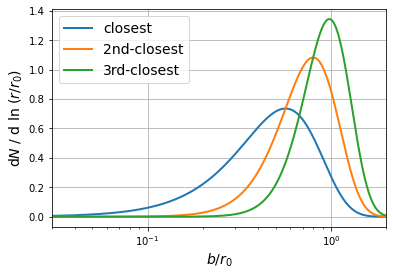

In [2]:
ri = np.logspace(-2,1, 500)
plt.plot(ri, em.knn_distribution(ri, 1., k=1) * ri, label="closest", lw=2)
plt.plot(ri, em.knn_distribution(ri, 1., k=2) * ri, label="2nd-closest", lw=2)
plt.plot(ri, em.knn_distribution(ri, 1., k=3) * ri, label="3rd-closest", lw=2)

plt.grid()
plt.xlabel(r"$b / r_0$", fontsize=14)
plt.xscale("log")
plt.ylabel(r"d$N$ / d ln $(r/r_0)$", fontsize=14)
plt.xlim(3e-2, 2e0)
plt.legend(fontsize=14)

plt.savefig("img/closest_encounter_distribution.pdf", bbox_inches="tight")

# Distribution of shock parameters

Sampling Beff3 and Beff4 takes a while, if you want to save some time reduce Nsamp e.g. to 10000. Also note that you might run into memory problems here if you have a small machine, since the full histories are created in memory and then combined into effective B values

In [3]:
%%time
Nsamp = 100000
Bmin = 1e-2
Bstar = 1.
B = em.sample_encounters_B(Nsamp, Bmin, Bstar=Bstar)

Beff1 = em.sample_effective_B(Nsamp, Bstar=1., Bmin=1e-1, p=1.2)
Beff2 = em.sample_effective_B(Nsamp, Bstar=1., Bmin=1e-2, p=1.2)
Beff3 = em.sample_effective_B(Nsamp, Bstar=1., Bmin=1e-3, p=1.2)
Beff4 = em.sample_effective_B(Nsamp, Bstar=1., Bmin=1e-4, p=1.2)

CPU times: user 2min 28s, sys: 34.4 s, total: 3min 2s
Wall time: 3min 3s


In [4]:
%%time
# This is an accelerator function, that samples from a first calculated histogram which is also be cached
# Later on we use this to accelerate computations
# On first execution ~ 3 minutes, but later ~50ms
Beff4_quick= em.sample_effective_B_hist(100000, Bminfac=1e-4, p=1.2, initial_sample=100000, cachefile="%s/Beff_hist.hdf5" % cachedir)

CPU times: user 25.1 ms, sys: 2.8 ms, total: 27.9 ms
Wall time: 31.1 ms


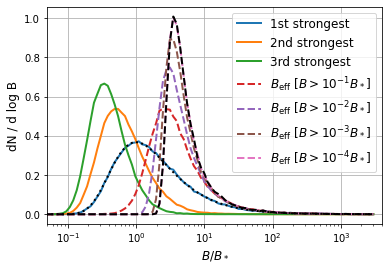

In [5]:
bins = np.logspace(-1.5,3.5,100)
dbin = np.log(bins[1:]) - np.log(bins[:-1])
Bcent = np.sqrt(bins[1:]*bins[:-1])

ni,_ = np.histogram(B[:,0], bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label="1st strongest", lw=2)

ni,_ = np.histogram(B[:,1], bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label="2nd strongest", lw=2)

ni,_ = np.histogram(B[:,2], bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label="3rd strongest", lw=2)

ni,_ = np.histogram(Beff1, bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label=r"$B_{\rm{eff}}$ [$B > 10^{-1} B_*$]", lw=2,  ls="dashed") #color=plt.get_cmap("viridis")(0.),

ni,_ = np.histogram(Beff2, bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label=r"$B_{\rm{eff}}$ [$B > 10^{-2} B_*$]", lw=2,  ls="dashed") #color=plt.get_cmap("viridis")(0.3),

ni,_ = np.histogram(Beff3, bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label=r"$B_{\rm{eff}}$ [$B > 10^{-3} B_*$]", lw=2, ls="dashed")

ni,_ = np.histogram(Beff4, bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label=r"$B_{\rm{eff}}$ [$B > 10^{-4} B_*$]", lw=2, ls="dashed")

plt.xscale("log")

def fana(B, Bstar):
    return Bstar/B**2 * np.exp(-Bstar/B)
    
plt.xlabel(r"$B / B_*$", fontsize=12)
plt.ylabel(r"dN / d log B", fontsize=12)
plt.grid("grid")
plt.legend(fontsize=12)

plt.xlim(5e-2,4e3)

plt.savefig("img/shock_distribution.pdf", bbox_inches="tight")

# Two small checks that we don't put in the publication figure
plt.plot(Bcent, fana(Bcent, Bstar)*Bcent, color="black", ls="dotted", label="analytic distribution", lw=2)
ni,_ = np.histogram(Beff4_quick, bins=bins)
plt.plot(Bcent, ni/dbin/Nsamp, label=r"quick [$B > 10^{-4} B_*$]", lw=2, ls="dashed", color="black")

# Encounters in the Milky Way

In [6]:
mw = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir)
orbits = mw.create_dm_orbits(20000, nsteps=50000, rmax=400e3, addinfo=True, adaptive=True, subsamp=500)

Reading result of previous calculation from ../caches/contracted_nfw.hdf5 (i=20)
reading


In [7]:
%autoreload

In [8]:
r = np.linalg.norm(orbits["pos"][::50], axis=-1)
chi = orbits["chi_star"][-1] * np.ones_like(orbits["chi_star"][::50])
chi = np.clip(chi, 1e-8, None)
chitot = (orbits["chi_star"][-1] + 0.04*orbits["chi_dm"][-1]) * np.ones_like(orbits["chi_star"][::50])
mass = orbits["mass"]*np.ones_like(orbits["chi_star"][::50])

Bstrongest = em.sample_strongest_B_analytic(2.*np.pi*chi*mw.G)
ri, perc = em.get_percentile_profile(r/1000., Bstrongest, weights=mass)

Bstrongest_tot = em.sample_strongest_B_analytic(2.*np.pi*chitot*mw.G)
ri, perc2 = em.get_percentile_profile(r/1000., Bstrongest_tot, weights=mass)

<ipython-input-9-3c038c136427>:11: RuntimeWarning: divide by zero encountered in true_divide
  return 2.*Mstar*mw.G / (b**2 * v) / (const.parsec/const.au)**2
<ipython-input-9-3c038c136427>:11: RuntimeWarning: divide by zero encountered in true_divide
  return 2.*Mstar*mw.G / (b**2 * v) / (const.parsec/const.au)**2
<ipython-input-9-3c038c136427>:11: RuntimeWarning: divide by zero encountered in true_divide
  return 2.*Mstar*mw.G / (b**2 * v) / (const.parsec/const.au)**2
<ipython-input-9-3c038c136427>:11: RuntimeWarning: divide by zero encountered in true_divide
  return 2.*Mstar*mw.G / (b**2 * v) / (const.parsec/const.au)**2


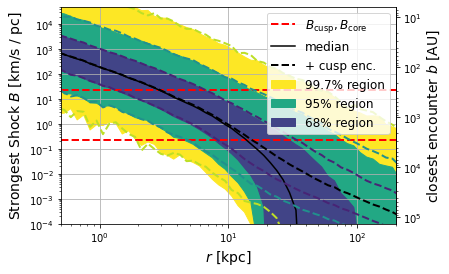

In [9]:
plt.axhline(0.224, ls="--", label=r"$B_{\rm{cusp}}, B_{\rm{core}}$", color="red", lw=2)
plt.axhline(23.7, ls="--", color="red", lw=2)
em.percentile_plot(ri, perc, ylabel=r"Strongest Shock $B$ [km/s / pc]", loc="lower left")
plt.ylim(1e-4, 5e4)

def B_to_b(B):
    Mstar, v = 1., 200
    return np.sqrt(2.*Mstar*mw.G / (B * v)) * (const.parsec/const.au)
def b_to_B(b):
    Mstar, v = 1., 200
    return 2.*Mstar*mw.G / (b**2 * v) / (const.parsec/const.au)**2
ax_chiG = plt.gca().secondary_yaxis('right', functions=(B_to_b, b_to_B))
ax_chiG.set_ylabel("closest encounter $b$ [AU]", fontsize=14)

plt.legend(loc="upper right", fontsize=12)
plt.savefig("img/radial_strongest_shock_and_encounter.pdf", bbox_inches="tight")

for i in (0,1,2,4,5,6):
    icol = min(i, 6-i)
    vi =[0.,0.4,0.8]
    plt.plot(ri, perc2[:,i], linestyle="dashed", color=plt.get_cmap("viridis_r")(vi[icol]+0.1),lw=2)
plt.plot(ri, perc2[:,3], linestyle="dashed", color="black",lw=2, label="+ cusp enc.")
plt.legend(loc="upper right", fontsize=12)

plt.savefig("img/radial_strongest_shock_and_encounter_with_cusps.pdf", bbox_inches="tight")

# Effective Shock

In [10]:
Beff = em.sample_effective_B_hist(chi.shape, Bminfac=1e-4, p=1.2, initial_sample=100000, cachefile="%s/Beff_hist.hdf5" % cachedir) * (2.*np.pi*chi*mw.G)
ri, perc = em.get_percentile_profile(r/1000., Beff, weights=mass)

Beff2 = em.sample_effective_B_hist(chi.shape, Bminfac=1e-4, p=1.2, initial_sample=100000, cachefile="%s/Beff_hist.hdf5" % cachedir) * (2.*np.pi*chitot*mw.G)
ri, perc2 = em.get_percentile_profile(r/1000., Beff2, weights=mass)

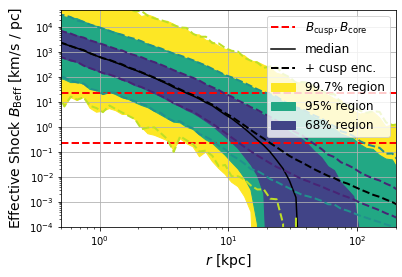

In [11]:
plt.axhline(0.224, ls="--", label=r"$B_{\rm{cusp}}, B_{\rm{core}}$", color="red", lw=2)
plt.axhline(23.7, ls="--", color="red", lw=2)
em.percentile_plot(ri, perc, ylabel=r"Effective Shock $B_{\rm{Beff}}$ [km/s / pc]", loc="lower left")
plt.ylim(1e-4, 5e4)


plt.legend(loc="upper right", fontsize=12)
plt.savefig("img/radial_effective_shock.pdf", bbox_inches="tight")

for i in (0,1,2,4,5,6):
    icol = min(i, 6-i)
    vi =[0.,0.4,0.8]
    plt.plot(ri, perc2[:,i], linestyle="dashed", color=plt.get_cmap("viridis_r")(vi[icol]+0.1),lw=2)
plt.plot(ri, perc2[:,3], linestyle="dashed", color="black",lw=2, label="+ cusp enc.")
plt.legend(loc="upper right", fontsize=12)

plt.savefig("img/radial_effective_shock_with_cusps.pdf", bbox_inches="tight")